<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/adaptive_newarch_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy

In [ ]:
# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, data_idx, data_t0, data_sup_b_train, layers, N_train, batch_size,load = False, file=None):
        
#============================================================================================================================#
#=============================================Loading data ==================================================================#
#============================================================================================================================#
        self.data_t0 = data_t0
        self.data_sup_b_train = data_sup_b_train
        self.data_idx = data_idx
        self.N_train = N_train
        self.batch_size=batch_size

        self.lowb = data_idx.min(0)  
        self.upb = data_idx.max(0)

        self.layers = layers

#============================================================================================================================#
#=============================================Initializing NN================================================================#
#============================================================================================================================#
        if load==True:
            # collecting weights and biases from the pickle file
            self.weights,self.biases,self.ewanb=self.load_parameters(file,self.layers)
            
            # loading encoder weights and biases from pickle file
            self.encoder_weights_1=self.ewandb[0]
            self.encoder_biases_1=self.ewandb[2]

            self.encoder_weights_2=self.ewandb[1]
            self.encoder_biases_2=self.ewandb[3]

        if load ==False:
            self.weights, self.biases = self.initialize_NN(layers)
            self.encoder_weights_1=self.xavier_init([3,self.layers[1]])
            self.encoder_biases_1=self.xavier_init([1,self.layers[1]])

            self.encoder_weights_2=self.xavier_init([3,self.layers[1]])
            self.encoder_biases_2=self.xavier_init([1,self.layers[1]])
            
        # Adaptive re-weighting constants
        self.beta=0.9
        self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions
        self.adaptive_constant_ics_val=np.array(1.0)  # arw for initial conditions

#============================================================================================================================#
#=============================================Specifying Placeholders========================================================#
#============================================================================================================================#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # learning rate placeholder
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
        # initial condition placeholders
        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # boundary condition placeholders
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        # domain residual placeholders
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)
        
#============================================================================================================================#
#=============================================Evaluating Predictions=========================================================#
#============================================================================================================================#

        # Initial value predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary value predictions

        self.u_bc1_pred, self.v_bc1_pred,_ = self.net_NS(self.x_bc1_tf, self.y_bc1_tf,self.t_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred,_ = self.net_NS(self.x_bc2_tf, self.y_bc2_tf,self.t_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred,_ = self.net_NS(self.x_bc3_tf, self.y_bc3_tf,self.t_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred,_ = self.net_NS(self.x_bc4_tf, self.y_bc4_tf,self.t_bc4_tf)
        
        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

#============================================================================================================================#
#=============================================Defining loss fn===============================================================#
#============================================================================================================================#

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf)+tf.square(self.U_bc2_pred - self.U_bc2_tf)+tf.square(self.U_bc3_pred - self.U_bc3_tf)+tf.square(self.U_bc4_pred - self.U_bc4_tf)))

        self.loss_ics=self.adaptive_constant_ics_tf*(tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)))
        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs + self.loss_ics

#============================================================================================================================#
#=============================================Setting up optimizer===========================================================#
#============================================================================================================================#
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

#============================================================================================================================#
#=============================================Adaptive weighting constants===================================================#
#============================================================================================================================#

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        
        for i in range(len(self.layers)-1):
          self.grad_res.append(tf.gradients(self.loss_res,self.weights[i])[0])
          self.grad_bcs.append(tf.gradients(self.loss_bcs,self.weights[i])[0])
          self.grad_ics.append(tf.gradients(self.loss_ics,self.weights[i])[0])
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i]))
          )
          self.adaptive_constant_ics_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_ics[i]))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adpative_constant_ics=tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        
#============================================================================================================================#
#=============================================initializing session===========================================================#
#============================================================================================================================#

        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

#============================================================================================================================#
#=============================================Data in batches================================================================#
#============================================================================================================================#

        # Creating batches for domain data
    def summon_batch_domain(self,batch_size,start):
      ''' 
      This function returns a list containing randomnly picked points from the domain
      '''
      data=copy.deepcopy(self.data_idx)
      points=[]

      for i in range(start,len(data),batch_size): # Something is wrong here

        points.append(data[i:i+batch_size,0:3])
        break # breaks after the first iteration

      return points

    def domain_batches(self,batch_size):
      '''
      This function is used to call the domain data points in batches
      This function returns an array of arrays of shape(438,1) each of the 438 arrays
      will have batch size number of points
      '''
      batches=[]
      num_batches=math.ceil(self.N_train/batch_size)

      for i in range(0,len(data_idx),batch_size):
        batches.append(self.summon_batch_domain(batch_size,i))

      return np.asarray(batches,dtype=object) 

# Creating batches for initial conditions
    def summon_batch_ic(self,batch_size,start):

      data=copy.deepcopy(data_t0)
      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points
    def ic_batches(self,batch_size):
      batches=[]
      num_batches=math.ceil(self.data_t0.shape[0]/batch_size)

      for i in range(0,len(self.data_t0),batch_size):
        batches.append(self.summon_batch_ic(batch_size,i))

      return np.asarray(batches,dtype=object)       

# Creatng batches for boundary condition
    def summon_batch_bc(self,batch_size,bc_con,start):
      
      if bc_con==1:
        data=copy.deepcopy(data_sup_b_train[0:20000,:])
      elif bc_con==2:
        data=copy.deepcopy(data_sup_b_train[20000:40000,:])
      elif bc_con==3:
        data=copy.deepcopy(data_sup_b_train[40000:60000,:])
      elif bc_con==4:
        data=copy.deepcopy(data_sup_b_train[60000:80000,:])

      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points	
    
    def bc_batches(self,batch_size,bc_con):

      batches=[]
      
      for i in range(0,int(len(data_sup_b_train)/4),batch_size):
        batches.append(self.summon_batch_bc(batch_size,bc_con,i))

      return np.asarray(batches,dtype=object) 

#============================================================================================================================#
#=============================================Utility fns= ==================================================================#
#============================================================================================================================#

# initialize the weights and biases
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# saving the weights and biases for transfer learning
    def save_parameters_encoder(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        enc_w1=self.sess.run(self.encoder_weights_1)
        enc_b1=self.sess.run(self.encoder_biases_1)
        enc_w2=self.sess.run(self.encoder_weights_2)
        enc_b2=self.sess.run(self.encoder_biases_2)
                
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases,enc_w1,enc_b1,enc_w2,enc_b2],f)
            print("Parameters are saved in pickle file")

    def load_parameters_encoder(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases,enc_w1,enc_b1,enc_w2,enc_b2=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
        
        ew1=tf.Variable(enc_w1)
        ew2=tf.Variable(enc_w2)
        eb1=tf.Variable(enc_b1)
        eb2=tf.Variable(enc_b2)
        
        ewandb=[ew1,ew2,eb1,eb2]        
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases,ewandb
    
    
#============================================================================================================================#
#=============================================Neural_net setup===============================================================#
#============================================================================================================================#


    def neural_net(self, X):
        num_layers = len(self.layers)
        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        encoder_1= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_1),self.encoder_biases_1))
        encoder_2= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_2),self.encoder_biases_2))
        
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_1)+ \
                tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_2)
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

#============================================================================================================================#
#=============================================Training algorithms============================================================#
#============================================================================================================================#

    def Adam_train(self, epochs=5000):

        start_time = time.time()
        
        for epoch in range(epochs):
          # number of batch will vary for domain, initial and boundary conditions.
            dom_bat_no=np.random.randint(1,(math.ceil(self.N_train/self.batch_size)))
            init_bat_no=np.random.randint(1,(math.ceil(self.data_t0.shape[0]/self.batch_size)))
            bound_bat_no=np.random.randint(1,(math.ceil((self.data_sup_b_train.shape[0]/4)/self.batch_size)))
            
            # call batches here 
            d_batch = self.domain_batches (self.batch_size)[dom_bat_no][0]
            i_batch = self.ic_batches     (self.batch_size)[init_bat_no][0]
            b_batch1 = self.bc_batches     (self.batch_size,1)[bound_bat_no][0]
            b_batch2 = self.bc_batches     (self.batch_size,2)[bound_bat_no][0]
            b_batch3 = self.bc_batches     (self.batch_size,3)[bound_bat_no][0]
            b_batch4 = self.bc_batches     (self.batch_size,4)[bound_bat_no][0]
            
            tf_dict = {
                  self.x_ini_tf: i_batch[:,0:1] , 
                  self.y_ini_tf: i_batch[:,1:2] ,
                  self.t_ini_tf: i_batch[:,2:3] , 
                  self.u_ini_tf: i_batch[:,3:4],
                  self.v_ini_tf: i_batch[:,4:5] , 

                  self.x_bc1_tf: b_batch1[:,0:1] ,
                  self.y_bc1_tf: b_batch1[:,1:2] , 
                  self.t_bc1_tf: b_batch1[:,2:3] ,
                  self.U_bc1_tf: b_batch1[:,3:5] ,

                  self.x_bc2_tf: b_batch2[:,0:1] ,
                  self.y_bc2_tf: b_batch2[:,1:2] , 
                  self.t_bc2_tf: b_batch2[:,2:3] ,
                  self.U_bc2_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc3_tf: b_batch3[:,0:1] ,
                  self.y_bc3_tf: b_batch3[:,1:2] , 
                  self.t_bc3_tf: b_batch3[:,2:3] ,
                  self.U_bc3_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc4_tf: b_batch4[:,0:1] ,
                  self.y_bc4_tf: b_batch4[:,1:2] , 
                  self.t_bc4_tf: b_batch4[:,2:3] ,
                  self.U_bc4_tf: b_batch1[:,3:5] ,
                  
                  self.x_tf: d_batch[:,0:1] , 
                  self.y_tf:d_batch[:,1:2] , 
                  self.t_tf:d_batch[:,2:3] ,

                  self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                  self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}

            # add the tf dict here 
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adpative_constant_ics,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val

                print('epoch: %d, Loss: %.3e, Time: %.2f' %
                      (epoch, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                start_time = time.time()
            
            if epoch !=0 and epoch %1000==0:
                self.save_parameters_encoder('params_3_laptop_run')

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

#============================================================================================================================#
#=============================================Predicting for test_data=======================================================#
#============================================================================================================================#


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data(N_train):
    # Load Data
    path=r"C:\Users\vamsi_oe20s302\Downloads\all_pressures"
    #path=r"C:\Users\Vamsi\Downloads\all_pressures"
    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)

    # Concatenating all the points
    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    data2=data1[:,:][data1[:,2]<=20]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]

    # Creating domain dataset size= (2000000,6)
    # It is from this dataset, we extract idx points for calculating the NS residual
    data_domain=data5[:,:][data5[:,1]<=ymax]

    # Creating initial condition dataset size=(10000,6)
    data_t0=data_domain[:,:][data_domain[:,2]==0]

    # Defining boundary conditions for the data
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    # Creating boundary conditions dataset size=(80000,6)
    data_sup_b_train = np.concatenate([bc1_data,bc2_data,bc3_data,bc4_data], 0)

    # Creating random indexes for domain residual sampling points
    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)

    # Extracting random points(x,y,t) from the domain dataset
    data_idx=data_domain[idx][:,0:3]
    
    return data_idx,data_t0,data_sup_b_train


In [ ]:

if __name__ == "__main__":

    N_train = 14000
    batch_size= 32

    layers = [3, 50,50,50, 2]
    
    # loading data
    data_idx,data_t0,data_sup_b_train = load_data(N_train)
    
    # Initializing the model for training
    model = pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=False,file=None)
    
#     Initializing model for testing by loading the pickle file
#     filedr='' # Enter the name of the pickle file
#     model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)
    
#      Training the model
     model.Adam_train(50000)
#     model.Adam_train(5000)
#     model.Adam_train(50000)
#     model.Adam_train(50000)
#     model.BFGS_train()








Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P620, pci bus id: 0000:01:00.0, compute capability: 6.1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



epoch: 0, Loss: 4.341e+00, Time: 38.80
constant_bcs_val: 7.309
constant_ics_val: 7.137
epoch: 10, Loss: 2.933e+00, Time: 24.33
constant_bcs_val: 7.051
constant_ics_val: 6.870
epoch: 20, Loss: 9.504e-01, Time: 23.24
constant_bcs_val: 7.710
constant_ics_val: 7.669
epoch: 30, Loss: 1.694e+00, Time: 25.00
constant_bcs_val: 7.476
constant_ics_val: 7.061
epoch: 40, Loss: 1.619e+00, Time: 24.41
constant_bcs_val: 7.110
constant_ics_val: 6.655
epoch: 50, Loss: 1.422e+00, Time: 24.73
const

epoch: 710, Loss: 5.360e-02, Time: 27.04
constant_bcs_val: 6.746
constant_ics_val: 4.773
epoch: 720, Loss: 5.316e-01, Time: 25.76
constant_bcs_val: 6.698
constant_ics_val: 4.465
epoch: 730, Loss: 2.337e-01, Time: 25.88
constant_bcs_val: 6.330
constant_ics_val: 4.587
epoch: 740, Loss: 6.301e-02, Time: 24.48
constant_bcs_val: 6.285
constant_ics_val: 4.527
epoch: 750, Loss: 1.686e-01, Time: 22.86
constant_bcs_val: 6.062
constant_ics_val: 4.367
epoch: 760, Loss: 7.550e-01, Time: 22.89
constant_bcs_val: 5.904
constant_ics_val: 4.205
epoch: 770, Loss: 1.650e-01, Time: 23.29
constant_bcs_val: 5.708
constant_ics_val: 3.935
epoch: 780, Loss: 1.417e-01, Time: 22.95
constant_bcs_val: 5.684
constant_ics_val: 3.935
epoch: 790, Loss: 5.233e-01, Time: 22.83
constant_bcs_val: 5.550
constant_ics_val: 3.837
epoch: 800, Loss: 1.234e-01, Time: 22.96
constant_bcs_val: 5.751
constant_ics_val: 4.643
epoch: 810, Loss: 1.726e-01, Time: 24.41
constant_bcs_val: 5.955
constant_ics_val: 4.599
epoch: 820, Loss: 4.6

epoch: 1620, Loss: 1.497e-01, Time: 25.49
constant_bcs_val: 7.410
constant_ics_val: 8.122
epoch: 1630, Loss: 1.550e+00, Time: 25.38
constant_bcs_val: 6.801
constant_ics_val: 7.372
epoch: 1640, Loss: 2.225e-01, Time: 27.28
constant_bcs_val: 6.519
constant_ics_val: 7.982
epoch: 1650, Loss: 9.087e-01, Time: 25.15
constant_bcs_val: 6.143
constant_ics_val: 7.351
epoch: 1660, Loss: 5.671e-01, Time: 25.45
constant_bcs_val: 7.780
constant_ics_val: 7.151
epoch: 1670, Loss: 4.105e-01, Time: 25.07
constant_bcs_val: 7.325
constant_ics_val: 6.661
epoch: 1680, Loss: 9.202e-01, Time: 24.93
constant_bcs_val: 6.743
constant_ics_val: 6.109
epoch: 1690, Loss: 1.351e-01, Time: 23.84
constant_bcs_val: 6.421
constant_ics_val: 6.116
epoch: 1700, Loss: 1.794e-01, Time: 24.78
constant_bcs_val: 8.214
constant_ics_val: 5.999
epoch: 1710, Loss: 4.054e-01, Time: 25.50
constant_bcs_val: 8.317
constant_ics_val: 5.698
epoch: 1720, Loss: 7.151e-01, Time: 24.77
constant_bcs_val: 7.976
constant_ics_val: 5.768
epoch: 173

epoch: 2530, Loss: 8.758e-02, Time: 27.05
constant_bcs_val: 9.024
constant_ics_val: 6.767
epoch: 2540, Loss: 1.884e-01, Time: 27.01
constant_bcs_val: 9.503
constant_ics_val: 6.633
epoch: 2550, Loss: 1.319e-01, Time: 26.93
constant_bcs_val: 8.839
constant_ics_val: 6.340
epoch: 2560, Loss: 2.578e+00, Time: 27.26
constant_bcs_val: 9.136
constant_ics_val: 5.802
epoch: 2570, Loss: 8.393e-02, Time: 26.90
constant_bcs_val: 9.499
constant_ics_val: 7.098
epoch: 2580, Loss: 6.726e-02, Time: 27.39
constant_bcs_val: 9.362
constant_ics_val: 8.072
epoch: 2590, Loss: 8.655e-01, Time: 26.69
constant_bcs_val: 9.506
constant_ics_val: 7.416
epoch: 2600, Loss: 1.439e-01, Time: 26.84
constant_bcs_val: 10.097
constant_ics_val: 7.288
epoch: 2610, Loss: 1.113e-01, Time: 27.34
constant_bcs_val: 10.206
constant_ics_val: 7.302
epoch: 2620, Loss: 7.649e-01, Time: 26.67
constant_bcs_val: 9.978
constant_ics_val: 6.845
epoch: 2630, Loss: 1.129e-01, Time: 26.59
constant_bcs_val: 9.932
constant_ics_val: 8.032
epoch: 2

epoch: 3440, Loss: 4.583e-01, Time: 27.19
constant_bcs_val: 8.775
constant_ics_val: 6.486
epoch: 3450, Loss: 4.297e-01, Time: 27.44
constant_bcs_val: 8.745
constant_ics_val: 5.994
epoch: 3460, Loss: 2.145e-01, Time: 27.30
constant_bcs_val: 8.206
constant_ics_val: 5.569
epoch: 3470, Loss: 1.047e-01, Time: 27.44
constant_bcs_val: 9.312
constant_ics_val: 5.810
epoch: 3480, Loss: 1.012e-01, Time: 27.31
constant_bcs_val: 9.599
constant_ics_val: 6.015
epoch: 3490, Loss: 1.543e+00, Time: 27.57
constant_bcs_val: 9.756
constant_ics_val: 5.666
epoch: 3500, Loss: 3.850e-01, Time: 27.51
constant_bcs_val: 9.674
constant_ics_val: 5.727
epoch: 3510, Loss: 2.366e-01, Time: 27.54
constant_bcs_val: 9.120
constant_ics_val: 5.414
epoch: 3520, Loss: 2.635e-01, Time: 27.35
constant_bcs_val: 8.926
constant_ics_val: 5.678
epoch: 3530, Loss: 4.458e-01, Time: 27.34
constant_bcs_val: 9.069
constant_ics_val: 5.484
epoch: 3540, Loss: 1.118e-01, Time: 27.64
constant_bcs_val: 9.234
constant_ics_val: 5.656
epoch: 355

epoch: 4340, Loss: 1.263e+00, Time: 28.31
constant_bcs_val: 9.323
constant_ics_val: 7.017
epoch: 4350, Loss: 6.670e-01, Time: 28.03
constant_bcs_val: 10.572
constant_ics_val: 7.090
epoch: 4360, Loss: 6.456e-01, Time: 28.34
constant_bcs_val: 11.340
constant_ics_val: 6.764
epoch: 4370, Loss: 4.804e-01, Time: 28.51
constant_bcs_val: 11.534
constant_ics_val: 6.323
epoch: 4380, Loss: 1.676e-01, Time: 28.05
constant_bcs_val: 11.716
constant_ics_val: 15.823
epoch: 4390, Loss: 9.741e-01, Time: 28.33
constant_bcs_val: 12.552
constant_ics_val: 14.970
epoch: 4400, Loss: 6.503e-01, Time: 28.15
constant_bcs_val: 12.182
constant_ics_val: 14.358
epoch: 4410, Loss: 6.545e-01, Time: 28.12
constant_bcs_val: 12.306
constant_ics_val: 13.350
epoch: 4420, Loss: 1.087e-01, Time: 28.29
constant_bcs_val: 11.782
constant_ics_val: 13.636
epoch: 4430, Loss: 1.466e+00, Time: 28.19
constant_bcs_val: 11.520
constant_ics_val: 12.544
epoch: 4440, Loss: 2.475e-01, Time: 28.06
constant_bcs_val: 11.466
constant_ics_val: 

epoch: 5230, Loss: 5.449e-01, Time: 28.05
constant_bcs_val: 16.889
constant_ics_val: 11.497
epoch: 5240, Loss: 2.424e-01, Time: 26.90
constant_bcs_val: 15.836
constant_ics_val: 10.625
epoch: 5250, Loss: 5.909e-01, Time: 27.96
constant_bcs_val: 17.436
constant_ics_val: 10.218
epoch: 5260, Loss: 4.825e-01, Time: 27.78
constant_bcs_val: 17.159
constant_ics_val: 10.063
epoch: 5270, Loss: 1.626e-01, Time: 27.81
constant_bcs_val: 16.726
constant_ics_val: 12.201
epoch: 5280, Loss: 4.142e-01, Time: 28.00
constant_bcs_val: 17.113
constant_ics_val: 11.473
epoch: 5290, Loss: 2.008e-01, Time: 27.93
constant_bcs_val: 17.587
constant_ics_val: 11.372
epoch: 5300, Loss: 7.317e-01, Time: 27.96
constant_bcs_val: 19.673
constant_ics_val: 10.732
epoch: 5310, Loss: 4.847e-01, Time: 28.02
constant_bcs_val: 27.962
constant_ics_val: 13.001
epoch: 5320, Loss: 9.860e-01, Time: 27.88
constant_bcs_val: 25.437
constant_ics_val: 11.865
epoch: 5330, Loss: 2.323e+00, Time: 27.81
constant_bcs_val: 24.082
constant_ics_

epoch: 6120, Loss: 2.212e-01, Time: 31.45
constant_bcs_val: 17.241
constant_ics_val: 26.845
epoch: 6130, Loss: 4.675e-01, Time: 31.44
constant_bcs_val: 16.306
constant_ics_val: 24.663
epoch: 6140, Loss: 5.763e-01, Time: 31.38
constant_bcs_val: 29.294
constant_ics_val: 26.536
epoch: 6150, Loss: 2.013e-01, Time: 31.43
constant_bcs_val: 27.010
constant_ics_val: 24.791
epoch: 6160, Loss: 3.448e-01, Time: 31.20
constant_bcs_val: 24.792
constant_ics_val: 22.675
epoch: 6170, Loss: 2.590e-01, Time: 31.35
constant_bcs_val: 24.011
constant_ics_val: 21.766
epoch: 6180, Loss: 4.318e-01, Time: 31.17
constant_bcs_val: 24.596
constant_ics_val: 25.968
epoch: 6190, Loss: 3.992e-01, Time: 31.21
constant_bcs_val: 25.806
constant_ics_val: 27.067
epoch: 6200, Loss: 3.972e-01, Time: 31.45
constant_bcs_val: 26.000
constant_ics_val: 25.969
epoch: 6210, Loss: 5.049e-01, Time: 31.11
constant_bcs_val: 23.804
constant_ics_val: 24.504
epoch: 6220, Loss: 2.741e-01, Time: 31.36
constant_bcs_val: 22.053
constant_ics_

epoch: 7010, Loss: 2.461e-01, Time: 28.43
constant_bcs_val: 24.834
constant_ics_val: 19.022
epoch: 7020, Loss: 6.799e-01, Time: 28.42
constant_bcs_val: 27.003
constant_ics_val: 33.356
epoch: 7030, Loss: 2.724e-01, Time: 28.61
constant_bcs_val: 26.043
constant_ics_val: 32.079
epoch: 7040, Loss: 9.565e-01, Time: 28.29
constant_bcs_val: 30.482
constant_ics_val: 29.565
epoch: 7050, Loss: 6.571e-01, Time: 28.59
constant_bcs_val: 30.281
constant_ics_val: 30.726
epoch: 7060, Loss: 2.813e+00, Time: 28.46
constant_bcs_val: 28.100
constant_ics_val: 27.868
epoch: 7070, Loss: 9.746e-01, Time: 28.48
constant_bcs_val: 25.945
constant_ics_val: 25.231
epoch: 7080, Loss: 3.705e-01, Time: 28.48
constant_bcs_val: 23.737
constant_ics_val: 23.141
epoch: 7090, Loss: 7.974e-01, Time: 28.27
constant_bcs_val: 22.359
constant_ics_val: 21.380
epoch: 7100, Loss: 1.115e+00, Time: 28.52
constant_bcs_val: 21.160
constant_ics_val: 19.940
epoch: 7110, Loss: 7.614e-01, Time: 28.50
constant_bcs_val: 19.556
constant_ics_

epoch: 7910, Loss: 5.069e-01, Time: 31.92
constant_bcs_val: 30.100
constant_ics_val: 22.027
epoch: 7920, Loss: 7.505e-01, Time: 33.57
constant_bcs_val: 27.372
constant_ics_val: 20.049
epoch: 7930, Loss: 6.808e-01, Time: 30.79
constant_bcs_val: 27.885
constant_ics_val: 19.185
epoch: 7940, Loss: 3.917e-01, Time: 30.13
constant_bcs_val: 28.629
constant_ics_val: 21.989
epoch: 7950, Loss: 2.078e-01, Time: 31.24
constant_bcs_val: 26.986
constant_ics_val: 20.589
epoch: 7960, Loss: 2.421e-01, Time: 31.71
constant_bcs_val: 24.934
constant_ics_val: 19.013
epoch: 7970, Loss: 7.718e-01, Time: 31.53
constant_bcs_val: 23.628
constant_ics_val: 17.456
epoch: 7980, Loss: 1.603e+00, Time: 31.66
constant_bcs_val: 21.415
constant_ics_val: 16.151
epoch: 7990, Loss: 2.745e-01, Time: 31.50
constant_bcs_val: 19.618
constant_ics_val: 14.852
epoch: 8000, Loss: 8.901e-02, Time: 32.06
constant_bcs_val: 18.901
constant_ics_val: 13.701
Parameters are saved in pickle file
epoch: 8010, Loss: 1.602e+00, Time: 31.86
co

epoch: 8800, Loss: 1.700e-01, Time: 28.09
constant_bcs_val: 22.035
constant_ics_val: 21.804
epoch: 8810, Loss: 1.018e-01, Time: 28.11
constant_bcs_val: 21.748
constant_ics_val: 20.569
epoch: 8820, Loss: 6.498e-01, Time: 28.15
constant_bcs_val: 20.449
constant_ics_val: 18.683
epoch: 8830, Loss: 1.817e-01, Time: 28.36
constant_bcs_val: 21.227
constant_ics_val: 18.284
epoch: 8840, Loss: 6.410e-01, Time: 28.24
constant_bcs_val: 21.262
constant_ics_val: 16.887
epoch: 8850, Loss: 2.290e-01, Time: 28.19
constant_bcs_val: 21.704
constant_ics_val: 15.965
epoch: 8860, Loss: 1.019e-01, Time: 28.20
constant_bcs_val: 21.583
constant_ics_val: 15.860
epoch: 8870, Loss: 2.243e-01, Time: 28.37
constant_bcs_val: 21.411
constant_ics_val: 14.751
epoch: 8880, Loss: 3.479e-01, Time: 28.19
constant_bcs_val: 21.719
constant_ics_val: 18.343
epoch: 8890, Loss: 1.051e-01, Time: 28.41
constant_bcs_val: 20.218
constant_ics_val: 17.860
epoch: 8900, Loss: 2.061e-01, Time: 28.33
constant_bcs_val: 22.675
constant_ics_

epoch: 9690, Loss: 2.149e-01, Time: 28.11
constant_bcs_val: 31.127
constant_ics_val: 22.482
epoch: 9700, Loss: 2.160e-01, Time: 28.34
constant_bcs_val: 29.589
constant_ics_val: 21.083
epoch: 9710, Loss: 7.479e-01, Time: 28.30
constant_bcs_val: 29.321
constant_ics_val: 20.113
epoch: 9720, Loss: 3.081e-01, Time: 27.83
constant_bcs_val: 26.769
constant_ics_val: 18.422
epoch: 9730, Loss: 4.546e-01, Time: 28.11
constant_bcs_val: 34.065
constant_ics_val: 25.232
epoch: 9740, Loss: 5.666e-01, Time: 28.04
constant_bcs_val: 31.950
constant_ics_val: 23.401
epoch: 9750, Loss: 1.260e+00, Time: 27.84
constant_bcs_val: 30.479
constant_ics_val: 21.361
epoch: 9760, Loss: 4.709e-01, Time: 28.11
constant_bcs_val: 27.609
constant_ics_val: 19.320
epoch: 9770, Loss: 7.206e-01, Time: 28.02
constant_bcs_val: 35.212
constant_ics_val: 51.734
epoch: 9780, Loss: 1.094e+00, Time: 27.75
constant_bcs_val: 42.359
constant_ics_val: 49.845
epoch: 9790, Loss: 6.323e-01, Time: 27.96
constant_bcs_val: 40.019
constant_ics_

epoch: 10580, Loss: 1.634e-01, Time: 27.91
constant_bcs_val: 26.165
constant_ics_val: 20.598
epoch: 10590, Loss: 8.679e-01, Time: 28.11
constant_bcs_val: 30.986
constant_ics_val: 20.577
epoch: 10600, Loss: 1.983e+00, Time: 28.08
constant_bcs_val: 34.239
constant_ics_val: 19.364
epoch: 10610, Loss: 1.664e+00, Time: 27.93
constant_bcs_val: 39.872
constant_ics_val: 19.432
epoch: 10620, Loss: 1.719e-01, Time: 28.21
constant_bcs_val: 36.737
constant_ics_val: 18.567
epoch: 10630, Loss: 5.613e-01, Time: 28.00
constant_bcs_val: 34.217
constant_ics_val: 16.915
epoch: 10640, Loss: 2.116e-01, Time: 28.09
constant_bcs_val: 31.022
constant_ics_val: 15.462
epoch: 10650, Loss: 3.004e-01, Time: 28.07
constant_bcs_val: 29.767
constant_ics_val: 15.812
epoch: 10660, Loss: 2.023e-01, Time: 27.95
constant_bcs_val: 28.091
constant_ics_val: 15.212
epoch: 10670, Loss: 7.355e-01, Time: 28.15
constant_bcs_val: 36.078
constant_ics_val: 14.689
epoch: 10680, Loss: 5.820e-01, Time: 28.20
constant_bcs_val: 34.989
co

epoch: 11460, Loss: 2.103e-01, Time: 28.25
constant_bcs_val: 24.226
constant_ics_val: 15.501
epoch: 11470, Loss: 4.390e-01, Time: 28.51
constant_bcs_val: 28.190
constant_ics_val: 14.475
epoch: 11480, Loss: 5.375e-01, Time: 27.91
constant_bcs_val: 26.231
constant_ics_val: 13.841
epoch: 11490, Loss: 8.934e-01, Time: 28.47
constant_bcs_val: 33.596
constant_ics_val: 13.297
epoch: 11500, Loss: 6.192e-01, Time: 28.28
constant_bcs_val: 34.175
constant_ics_val: 15.278
epoch: 11510, Loss: 5.979e-01, Time: 28.12
constant_bcs_val: 33.738
constant_ics_val: 16.433
epoch: 11520, Loss: 1.144e-01, Time: 28.21
constant_bcs_val: 31.305
constant_ics_val: 16.103
epoch: 11530, Loss: 6.572e-01, Time: 28.25
constant_bcs_val: 39.532
constant_ics_val: 16.585
epoch: 11540, Loss: 2.049e-01, Time: 28.38
constant_bcs_val: 35.711
constant_ics_val: 15.234
epoch: 11550, Loss: 2.381e-01, Time: 28.12
constant_bcs_val: 34.324
constant_ics_val: 18.238
epoch: 11560, Loss: 5.052e-01, Time: 27.84
constant_bcs_val: 33.487
co

epoch: 12340, Loss: 4.513e-01, Time: 27.85
constant_bcs_val: 27.001
constant_ics_val: 15.969
epoch: 12350, Loss: 1.484e-01, Time: 28.18
constant_bcs_val: 25.908
constant_ics_val: 15.065
epoch: 12360, Loss: 3.430e-01, Time: 28.12
constant_bcs_val: 29.015
constant_ics_val: 26.555
epoch: 12370, Loss: 1.104e+00, Time: 28.19
constant_bcs_val: 29.466
constant_ics_val: 24.509
epoch: 12380, Loss: 4.974e-01, Time: 28.00
constant_bcs_val: 26.842
constant_ics_val: 22.359
epoch: 12390, Loss: 5.303e-01, Time: 28.00
constant_bcs_val: 26.738
constant_ics_val: 21.135
epoch: 12400, Loss: 5.932e-01, Time: 27.96
constant_bcs_val: 33.988
constant_ics_val: 21.197
epoch: 12410, Loss: 2.365e-01, Time: 28.02
constant_bcs_val: 42.007
constant_ics_val: 26.075
epoch: 12420, Loss: 2.284e-01, Time: 27.86
constant_bcs_val: 37.969
constant_ics_val: 23.997
epoch: 12430, Loss: 5.651e-01, Time: 27.84
constant_bcs_val: 36.337
constant_ics_val: 53.639
epoch: 12440, Loss: 4.160e-01, Time: 28.07
constant_bcs_val: 46.003
co

epoch: 13220, Loss: 2.667e-01, Time: 28.29
constant_bcs_val: 44.950
constant_ics_val: 23.574
epoch: 13230, Loss: 1.307e-01, Time: 28.44
constant_bcs_val: 40.809
constant_ics_val: 21.491
epoch: 13240, Loss: 3.343e+00, Time: 28.20
constant_bcs_val: 36.744
constant_ics_val: 19.457
epoch: 13250, Loss: 3.186e-01, Time: 28.29
constant_bcs_val: 49.194
constant_ics_val: 25.537
epoch: 13260, Loss: 1.043e-01, Time: 28.29
constant_bcs_val: 46.217
constant_ics_val: 24.777
epoch: 13270, Loss: 4.149e-01, Time: 28.23
constant_bcs_val: 42.410
constant_ics_val: 22.591
epoch: 13280, Loss: 3.218e-01, Time: 28.37
constant_bcs_val: 38.891
constant_ics_val: 20.662
epoch: 13290, Loss: 5.445e-01, Time: 28.15
constant_bcs_val: 36.977
constant_ics_val: 19.071
epoch: 13300, Loss: 1.558e-01, Time: 28.38
constant_bcs_val: 34.023
constant_ics_val: 19.239
epoch: 13310, Loss: 6.985e-01, Time: 28.34
constant_bcs_val: 38.634
constant_ics_val: 24.429
epoch: 13320, Loss: 2.924e-01, Time: 28.30
constant_bcs_val: 36.002
co

epoch: 14100, Loss: 1.892e-01, Time: 27.88
constant_bcs_val: 40.669
constant_ics_val: 29.867
epoch: 14110, Loss: 7.396e-01, Time: 28.02
constant_bcs_val: 38.969
constant_ics_val: 28.898
epoch: 14120, Loss: 2.226e-01, Time: 27.95
constant_bcs_val: 36.811
constant_ics_val: 26.523
epoch: 14130, Loss: 1.687e+00, Time: 28.13
constant_bcs_val: 34.729
constant_ics_val: 24.086
epoch: 14140, Loss: 1.912e-01, Time: 28.03
constant_bcs_val: 31.605
constant_ics_val: 21.837
epoch: 14150, Loss: 2.177e+00, Time: 28.12
constant_bcs_val: 28.594
constant_ics_val: 21.592
epoch: 14160, Loss: 2.075e-01, Time: 28.18
constant_bcs_val: 26.261
constant_ics_val: 19.673
epoch: 14170, Loss: 1.871e-01, Time: 28.00
constant_bcs_val: 24.332
constant_ics_val: 18.050
epoch: 14180, Loss: 1.238e-01, Time: 28.37
constant_bcs_val: 23.531
constant_ics_val: 17.990
epoch: 14190, Loss: 7.496e-01, Time: 28.24
constant_bcs_val: 23.050
constant_ics_val: 16.424
epoch: 14200, Loss: 2.365e-01, Time: 28.37
constant_bcs_val: 28.782
co

epoch: 14990, Loss: 2.743e-01, Time: 28.46
constant_bcs_val: 52.229
constant_ics_val: 26.695
epoch: 15000, Loss: 2.933e-01, Time: 28.38
constant_bcs_val: 48.048
constant_ics_val: 29.050
Parameters are saved in pickle file
epoch: 15010, Loss: 1.481e-01, Time: 28.40
constant_bcs_val: 46.682
constant_ics_val: 26.975
epoch: 15020, Loss: 1.154e+00, Time: 27.87
constant_bcs_val: 46.088
constant_ics_val: 25.104
epoch: 15030, Loss: 2.828e-01, Time: 28.14
constant_bcs_val: 44.322
constant_ics_val: 23.201
epoch: 15040, Loss: 2.390e-01, Time: 28.21
constant_bcs_val: 40.511
constant_ics_val: 21.943
epoch: 15050, Loss: 1.033e+00, Time: 28.21
constant_bcs_val: 36.879
constant_ics_val: 19.794
epoch: 15060, Loss: 2.396e-01, Time: 28.04
constant_bcs_val: 41.504
constant_ics_val: 19.164
epoch: 15070, Loss: 6.947e-02, Time: 28.15
constant_bcs_val: 38.137
constant_ics_val: 18.695
epoch: 15080, Loss: 3.670e-01, Time: 28.21
constant_bcs_val: 42.601
constant_ics_val: 24.354
epoch: 15090, Loss: 1.445e-01, Tim

epoch: 15870, Loss: 2.680e-01, Time: 28.50
constant_bcs_val: 42.628
constant_ics_val: 32.417
epoch: 15880, Loss: 4.404e-01, Time: 28.13
constant_bcs_val: 38.418
constant_ics_val: 29.435
epoch: 15890, Loss: 3.593e-01, Time: 28.36
constant_bcs_val: 41.118
constant_ics_val: 31.421
epoch: 15900, Loss: 1.165e-01, Time: 28.37
constant_bcs_val: 38.512
constant_ics_val: 28.442
epoch: 15910, Loss: 1.400e-01, Time: 28.24
constant_bcs_val: 35.577
constant_ics_val: 25.961
epoch: 15920, Loss: 2.316e-01, Time: 28.35
constant_bcs_val: 41.643
constant_ics_val: 26.707
epoch: 15930, Loss: 7.221e-01, Time: 28.13
constant_bcs_val: 37.566
constant_ics_val: 24.100
epoch: 15940, Loss: 7.711e-02, Time: 28.19
constant_bcs_val: 34.492
constant_ics_val: 22.402
epoch: 15950, Loss: 7.964e-01, Time: 28.39
constant_bcs_val: 48.210
constant_ics_val: 21.627
epoch: 15960, Loss: 7.670e-02, Time: 28.22
constant_bcs_val: 44.866
constant_ics_val: 20.554
epoch: 15970, Loss: 3.152e-01, Time: 28.40
constant_bcs_val: 40.765
co

epoch: 16750, Loss: 3.231e-01, Time: 28.17
constant_bcs_val: 54.903
constant_ics_val: 46.543
epoch: 16760, Loss: 2.930e-01, Time: 28.25
constant_bcs_val: 51.577
constant_ics_val: 43.091
epoch: 16770, Loss: 7.963e-01, Time: 28.24
constant_bcs_val: 46.652
constant_ics_val: 38.930
epoch: 16780, Loss: 4.548e-01, Time: 28.20
constant_bcs_val: 42.072
constant_ics_val: 35.128
epoch: 16790, Loss: 2.982e-01, Time: 27.93
constant_bcs_val: 39.534
constant_ics_val: 32.326
epoch: 16800, Loss: 3.109e-01, Time: 28.08
constant_bcs_val: 41.345
constant_ics_val: 31.581
epoch: 16810, Loss: 8.572e-01, Time: 28.17
constant_bcs_val: 39.794
constant_ics_val: 30.322
epoch: 16820, Loss: 1.096e-01, Time: 28.10
constant_bcs_val: 36.575
constant_ics_val: 27.577
epoch: 16830, Loss: 1.090e-01, Time: 28.07
constant_bcs_val: 33.768
constant_ics_val: 25.742
epoch: 16840, Loss: 4.103e-01, Time: 28.11
constant_bcs_val: 30.567
constant_ics_val: 23.268
epoch: 16850, Loss: 1.483e-01, Time: 28.13
constant_bcs_val: 27.943
co

epoch: 17630, Loss: 2.158e-01, Time: 28.18
constant_bcs_val: 35.548
constant_ics_val: 21.024
epoch: 17640, Loss: 1.684e-01, Time: 28.47
constant_bcs_val: 39.537
constant_ics_val: 23.585
epoch: 17650, Loss: 5.894e-01, Time: 28.12
constant_bcs_val: 44.599
constant_ics_val: 33.572
epoch: 17660, Loss: 3.467e-01, Time: 28.25
constant_bcs_val: 52.086
constant_ics_val: 32.798
epoch: 17670, Loss: 2.727e-01, Time: 28.26
constant_bcs_val: 50.047
constant_ics_val: 30.356
epoch: 17680, Loss: 5.104e-01, Time: 28.30
constant_bcs_val: 51.469
constant_ics_val: 43.377
epoch: 17690, Loss: 1.131e-01, Time: 28.42
constant_bcs_val: 46.497
constant_ics_val: 39.508
epoch: 17700, Loss: 1.617e-01, Time: 28.19
constant_bcs_val: 45.276
constant_ics_val: 38.107
epoch: 17710, Loss: 1.357e+00, Time: 28.33
constant_bcs_val: 50.268
constant_ics_val: 50.786
epoch: 17720, Loss: 3.389e-01, Time: 28.21
constant_bcs_val: 47.681
constant_ics_val: 47.590
epoch: 17730, Loss: 1.169e-01, Time: 28.29
constant_bcs_val: 43.409
co

epoch: 18510, Loss: 2.024e-01, Time: 28.38
constant_bcs_val: 33.360
constant_ics_val: 18.982
epoch: 18520, Loss: 5.230e-01, Time: 28.16
constant_bcs_val: 30.700
constant_ics_val: 18.551
epoch: 18530, Loss: 1.099e-01, Time: 28.32
constant_bcs_val: 29.878
constant_ics_val: 17.479
epoch: 18540, Loss: 1.787e+00, Time: 28.06
constant_bcs_val: 27.009
constant_ics_val: 15.926
epoch: 18550, Loss: 2.249e-01, Time: 28.35
constant_bcs_val: 25.609
constant_ics_val: 14.779
epoch: 18560, Loss: 1.716e-01, Time: 28.37
constant_bcs_val: 24.834
constant_ics_val: 15.861
epoch: 18570, Loss: 4.883e-01, Time: 28.45
constant_bcs_val: 27.884
constant_ics_val: 14.428
epoch: 18580, Loss: 5.890e-02, Time: 28.45
constant_bcs_val: 25.456
constant_ics_val: 13.459
epoch: 18590, Loss: 1.513e-01, Time: 28.20
constant_bcs_val: 25.714
constant_ics_val: 18.732
epoch: 18600, Loss: 7.455e-02, Time: 28.12
constant_bcs_val: 27.598
constant_ics_val: 18.768
epoch: 18610, Loss: 1.358e-01, Time: 27.99
constant_bcs_val: 29.960
co

epoch: 19390, Loss: 2.570e-01, Time: 28.16
constant_bcs_val: 47.671
constant_ics_val: 33.776
epoch: 19400, Loss: 2.606e-01, Time: 28.23
constant_bcs_val: 43.636
constant_ics_val: 30.742
epoch: 19410, Loss: 4.241e-01, Time: 28.24
constant_bcs_val: 40.001
constant_ics_val: 31.323
epoch: 19420, Loss: 3.393e-01, Time: 28.36
constant_bcs_val: 36.583
constant_ics_val: 28.554
epoch: 19430, Loss: 3.300e-01, Time: 28.28
constant_bcs_val: 34.153
constant_ics_val: 25.943
epoch: 19440, Loss: 4.970e-01, Time: 28.07
constant_bcs_val: 53.711
constant_ics_val: 32.636
epoch: 19450, Loss: 9.095e-02, Time: 28.12
constant_bcs_val: 48.471
constant_ics_val: 29.476
epoch: 19460, Loss: 4.703e-01, Time: 28.16
constant_bcs_val: 46.054
constant_ics_val: 27.280
epoch: 19470, Loss: 1.951e-01, Time: 28.15
constant_bcs_val: 42.098
constant_ics_val: 24.757
epoch: 19480, Loss: 8.285e-02, Time: 28.02
constant_bcs_val: 38.753
constant_ics_val: 22.692
epoch: 19490, Loss: 3.190e-01, Time: 28.38
constant_bcs_val: 35.352
co

epoch: 20270, Loss: 1.042e-01, Time: 27.93
constant_bcs_val: 39.906
constant_ics_val: 19.624
epoch: 20280, Loss: 8.124e-01, Time: 26.86
constant_bcs_val: 40.008
constant_ics_val: 19.077
epoch: 20290, Loss: 1.003e-01, Time: 27.76
constant_bcs_val: 38.901
constant_ics_val: 19.930
epoch: 20300, Loss: 3.029e-01, Time: 28.11
constant_bcs_val: 38.608
constant_ics_val: 18.296
epoch: 20310, Loss: 4.475e-01, Time: 27.73
constant_bcs_val: 39.437
constant_ics_val: 21.575
epoch: 20320, Loss: 2.522e-01, Time: 28.39
constant_bcs_val: 35.883
constant_ics_val: 19.543
epoch: 20330, Loss: 1.771e-01, Time: 28.25
constant_bcs_val: 38.171
constant_ics_val: 25.832
epoch: 20340, Loss: 3.043e-01, Time: 27.80
constant_bcs_val: 35.717
constant_ics_val: 23.802
epoch: 20350, Loss: 2.671e-01, Time: 28.06
constant_bcs_val: 35.522
constant_ics_val: 21.952
epoch: 20360, Loss: 1.399e+00, Time: 28.18
constant_bcs_val: 59.832
constant_ics_val: 22.879
epoch: 20370, Loss: 5.269e-01, Time: 27.93
constant_bcs_val: 56.035
co

epoch: 21150, Loss: 7.160e-01, Time: 28.17
constant_bcs_val: 63.296
constant_ics_val: 37.790
epoch: 21160, Loss: 3.840e-01, Time: 28.43
constant_bcs_val: 58.379
constant_ics_val: 35.120
epoch: 21170, Loss: 7.638e-01, Time: 28.32
constant_bcs_val: 56.159
constant_ics_val: 32.801
epoch: 21180, Loss: 1.206e-01, Time: 28.18
constant_bcs_val: 51.283
constant_ics_val: 29.751
epoch: 21190, Loss: 4.269e-01, Time: 28.05
constant_bcs_val: 46.981
constant_ics_val: 26.901
epoch: 21200, Loss: 2.259e-01, Time: 28.34
constant_bcs_val: 44.594
constant_ics_val: 26.336
epoch: 21210, Loss: 4.779e-01, Time: 28.42
constant_bcs_val: 42.266
constant_ics_val: 23.790
epoch: 21220, Loss: 6.112e-01, Time: 28.33
constant_bcs_val: 62.821
constant_ics_val: 25.723
epoch: 21230, Loss: 2.978e-01, Time: 28.18
constant_bcs_val: 59.714
constant_ics_val: 24.006
epoch: 21240, Loss: 3.661e+00, Time: 28.13
constant_bcs_val: 53.980
constant_ics_val: 24.124
epoch: 21250, Loss: 4.055e-01, Time: 27.64
constant_bcs_val: 49.331
co

epoch: 22030, Loss: 2.839e-01, Time: 28.16
constant_bcs_val: 30.517
constant_ics_val: 21.520
epoch: 22040, Loss: 5.484e-02, Time: 27.93
constant_bcs_val: 28.601
constant_ics_val: 21.918
epoch: 22050, Loss: 2.752e-01, Time: 28.17
constant_bcs_val: 26.647
constant_ics_val: 20.584
epoch: 22060, Loss: 6.501e-01, Time: 28.24
constant_bcs_val: 24.461
constant_ics_val: 18.701
epoch: 22070, Loss: 6.772e-01, Time: 28.03
constant_bcs_val: 24.562
constant_ics_val: 43.736
epoch: 22080, Loss: 6.822e-02, Time: 28.13
constant_bcs_val: 24.354
constant_ics_val: 40.234
epoch: 22090, Loss: 4.114e-01, Time: 28.09
constant_bcs_val: 45.480
constant_ics_val: 37.303
epoch: 22100, Loss: 8.937e-02, Time: 28.14
constant_bcs_val: 42.277
constant_ics_val: 36.118
epoch: 22110, Loss: 2.708e-01, Time: 28.24
constant_bcs_val: 41.448
constant_ics_val: 33.415
epoch: 22120, Loss: 2.820e-01, Time: 28.18
constant_bcs_val: 40.327
constant_ics_val: 30.826
epoch: 22130, Loss: 1.585e-01, Time: 28.42
constant_bcs_val: 37.484
co

epoch: 22920, Loss: 2.470e-01, Time: 28.09
constant_bcs_val: 26.633
constant_ics_val: 23.904
epoch: 22930, Loss: 3.716e-01, Time: 28.29
constant_bcs_val: 31.274
constant_ics_val: 24.524
epoch: 22940, Loss: 1.935e-01, Time: 28.30
constant_bcs_val: 28.436
constant_ics_val: 22.156
epoch: 22950, Loss: 1.056e-01, Time: 28.18
constant_bcs_val: 26.841
constant_ics_val: 20.276
epoch: 22960, Loss: 2.840e-01, Time: 28.51
constant_bcs_val: 42.409
constant_ics_val: 35.552
epoch: 22970, Loss: 4.786e-02, Time: 28.20
constant_bcs_val: 38.917
constant_ics_val: 32.323
epoch: 22980, Loss: 1.335e+00, Time: 28.19
constant_bcs_val: 59.552
constant_ics_val: 41.338
epoch: 22990, Loss: 3.637e-01, Time: 28.16
constant_bcs_val: 56.432
constant_ics_val: 37.596
epoch: 23000, Loss: 6.578e-01, Time: 28.03
constant_bcs_val: 54.470
constant_ics_val: 34.189
Parameters are saved in pickle file
epoch: 23010, Loss: 2.691e-01, Time: 28.16
constant_bcs_val: 53.528
constant_ics_val: 35.801
epoch: 23020, Loss: 1.521e-01, Tim

epoch: 23800, Loss: 6.651e-01, Time: 28.51
constant_bcs_val: 39.856
constant_ics_val: 30.206
epoch: 23810, Loss: 1.971e+00, Time: 28.07
constant_bcs_val: 36.032
constant_ics_val: 30.139
epoch: 23820, Loss: 8.487e-02, Time: 28.27
constant_bcs_val: 33.698
constant_ics_val: 28.683
epoch: 23830, Loss: 1.151e+00, Time: 27.91
constant_bcs_val: 70.936
constant_ics_val: 28.656
epoch: 23840, Loss: 3.631e-01, Time: 28.14
constant_bcs_val: 68.921
constant_ics_val: 27.733
epoch: 23850, Loss: 1.496e-01, Time: 28.08
constant_bcs_val: 62.532
constant_ics_val: 25.316
epoch: 23860, Loss: 4.020e-01, Time: 28.32
constant_bcs_val: 57.025
constant_ics_val: 23.147
epoch: 23870, Loss: 3.211e-01, Time: 28.10
constant_bcs_val: 52.674
constant_ics_val: 23.620
epoch: 23880, Loss: 1.797e+00, Time: 28.35
constant_bcs_val: 47.609
constant_ics_val: 22.166
epoch: 23890, Loss: 9.540e-02, Time: 28.24
constant_bcs_val: 43.398
constant_ics_val: 20.407
epoch: 23900, Loss: 6.578e-02, Time: 28.02
constant_bcs_val: 39.454
co

epoch: 24680, Loss: 1.278e-01, Time: 28.18
constant_bcs_val: 40.828
constant_ics_val: 27.247
epoch: 24690, Loss: 2.421e-01, Time: 28.18
constant_bcs_val: 40.874
constant_ics_val: 52.437
epoch: 24700, Loss: 1.370e-01, Time: 28.01
constant_bcs_val: 39.788
constant_ics_val: 48.759
epoch: 24710, Loss: 3.449e-01, Time: 28.08
constant_bcs_val: 57.695
constant_ics_val: 49.757
epoch: 24720, Loss: 2.350e-01, Time: 28.08
constant_bcs_val: 54.207
constant_ics_val: 46.359
epoch: 24730, Loss: 3.009e-01, Time: 28.08
constant_bcs_val: 50.916
constant_ics_val: 42.103
epoch: 24740, Loss: 3.985e-01, Time: 28.12
constant_bcs_val: 45.982
constant_ics_val: 38.136
epoch: 24750, Loss: 2.714e-01, Time: 28.07
constant_bcs_val: 42.456
constant_ics_val: 34.647
epoch: 24760, Loss: 1.759e-01, Time: 28.11
constant_bcs_val: 41.652
constant_ics_val: 33.351
epoch: 24770, Loss: 9.632e-01, Time: 28.64
constant_bcs_val: 39.006
constant_ics_val: 32.134
epoch: 24780, Loss: 3.795e-01, Time: 28.16
constant_bcs_val: 37.884
co

epoch: 25560, Loss: 1.131e-01, Time: 28.22
constant_bcs_val: 39.849
constant_ics_val: 28.057
epoch: 25570, Loss: 8.725e-01, Time: 28.55
constant_bcs_val: 40.425
constant_ics_val: 33.460
epoch: 25580, Loss: 6.219e-02, Time: 28.30
constant_bcs_val: 36.669
constant_ics_val: 30.644
epoch: 25590, Loss: 2.750e-01, Time: 28.22
constant_bcs_val: 35.297
constant_ics_val: 27.800
epoch: 25600, Loss: 1.277e-01, Time: 28.35
constant_bcs_val: 39.171
constant_ics_val: 26.649
epoch: 25610, Loss: 1.210e-01, Time: 28.28
constant_bcs_val: 41.446
constant_ics_val: 27.375
epoch: 25620, Loss: 4.111e-01, Time: 28.62
constant_bcs_val: 49.597
constant_ics_val: 28.872
epoch: 25630, Loss: 3.154e-01, Time: 28.11
constant_bcs_val: 52.447
constant_ics_val: 31.772
epoch: 25640, Loss: 2.741e-01, Time: 28.24
constant_bcs_val: 47.693
constant_ics_val: 28.937
epoch: 25650, Loss: 2.465e-01, Time: 28.04
constant_bcs_val: 43.199
constant_ics_val: 26.344
epoch: 25660, Loss: 5.048e-01, Time: 28.33
constant_bcs_val: 38.981
co

epoch: 26440, Loss: 3.830e-01, Time: 28.06
constant_bcs_val: 62.835
constant_ics_val: 26.113
epoch: 26450, Loss: 5.133e-01, Time: 28.24
constant_bcs_val: 57.034
constant_ics_val: 23.625
epoch: 26460, Loss: 2.023e-01, Time: 28.08
constant_bcs_val: 51.833
constant_ics_val: 21.512
epoch: 26470, Loss: 3.021e-01, Time: 28.08
constant_bcs_val: 46.921
constant_ics_val: 19.572
epoch: 26480, Loss: 1.907e+00, Time: 28.40
constant_bcs_val: 42.288
constant_ics_val: 18.625
epoch: 26490, Loss: 1.078e-01, Time: 28.31
constant_bcs_val: 38.462
constant_ics_val: 18.418
epoch: 26500, Loss: 7.600e-01, Time: 27.99
constant_bcs_val: 35.437
constant_ics_val: 17.083
epoch: 26510, Loss: 1.724e+00, Time: 28.28
constant_bcs_val: 33.060
constant_ics_val: 20.642
epoch: 26520, Loss: 6.294e-02, Time: 27.79
constant_bcs_val: 32.027
constant_ics_val: 19.106
epoch: 26530, Loss: 2.960e-01, Time: 28.06
constant_bcs_val: 29.003
constant_ics_val: 17.413
epoch: 26540, Loss: 2.023e-01, Time: 28.14
constant_bcs_val: 31.610
co

epoch: 27320, Loss: 2.651e-01, Time: 28.41
constant_bcs_val: 41.950
constant_ics_val: 33.149
epoch: 27330, Loss: 2.348e-01, Time: 28.35
constant_bcs_val: 38.235
constant_ics_val: 30.364
epoch: 27340, Loss: 1.841e-01, Time: 28.20
constant_bcs_val: 35.693
constant_ics_val: 29.258
epoch: 27350, Loss: 3.201e-01, Time: 28.05
constant_bcs_val: 32.929
constant_ics_val: 27.216
epoch: 27360, Loss: 8.978e-02, Time: 28.39
constant_bcs_val: 31.462
constant_ics_val: 25.127
epoch: 27370, Loss: 1.893e-01, Time: 28.48
constant_bcs_val: 29.816
constant_ics_val: 23.198
epoch: 27380, Loss: 1.593e-01, Time: 28.27
constant_bcs_val: 30.485
constant_ics_val: 21.982
epoch: 27390, Loss: 6.084e-01, Time: 28.18
constant_bcs_val: 37.489
constant_ics_val: 29.746
epoch: 27400, Loss: 1.772e-01, Time: 28.10
constant_bcs_val: 36.455
constant_ics_val: 31.159
epoch: 27410, Loss: 6.382e-02, Time: 28.23
constant_bcs_val: 34.462
constant_ics_val: 28.757
epoch: 27420, Loss: 3.155e-01, Time: 27.94
constant_bcs_val: 31.449
co

epoch: 28200, Loss: 5.994e-02, Time: 28.46
constant_bcs_val: 33.057
constant_ics_val: 22.586
epoch: 28210, Loss: 3.249e-01, Time: 28.21
constant_bcs_val: 38.474
constant_ics_val: 22.122
epoch: 28220, Loss: 4.000e-01, Time: 27.96
constant_bcs_val: 88.704
constant_ics_val: 37.598
epoch: 28230, Loss: 1.734e-01, Time: 28.18
constant_bcs_val: 80.629
constant_ics_val: 35.128
epoch: 28240, Loss: 2.755e+00, Time: 28.02
constant_bcs_val: 72.632
constant_ics_val: 32.117
epoch: 28250, Loss: 1.157e-01, Time: 28.38
constant_bcs_val: 67.351
constant_ics_val: 29.989
epoch: 28260, Loss: 2.288e-01, Time: 28.14
constant_bcs_val: 61.045
constant_ics_val: 27.270
epoch: 28270, Loss: 3.884e-01, Time: 28.43
constant_bcs_val: 55.756
constant_ics_val: 25.865
epoch: 28280, Loss: 1.882e+00, Time: 28.15
constant_bcs_val: 50.580
constant_ics_val: 29.905
epoch: 28290, Loss: 3.813e-01, Time: 28.25
constant_bcs_val: 45.818
constant_ics_val: 27.046
epoch: 28300, Loss: 2.844e-01, Time: 28.24
constant_bcs_val: 43.460
co

epoch: 29080, Loss: 2.890e+00, Time: 28.18
constant_bcs_val: 43.382
constant_ics_val: 23.648
epoch: 29090, Loss: 2.992e-01, Time: 28.12
constant_bcs_val: 41.990
constant_ics_val: 21.876
epoch: 29100, Loss: 5.356e-01, Time: 28.03
constant_bcs_val: 51.889
constant_ics_val: 21.384
epoch: 29110, Loss: 5.153e-01, Time: 28.18
constant_bcs_val: 46.801
constant_ics_val: 19.445
epoch: 29120, Loss: 3.536e-01, Time: 28.28
constant_bcs_val: 42.643
constant_ics_val: 19.019
epoch: 29130, Loss: 5.686e-02, Time: 28.18
constant_bcs_val: 39.456
constant_ics_val: 17.553
epoch: 29140, Loss: 5.592e-02, Time: 28.14
constant_bcs_val: 35.898
constant_ics_val: 16.471
epoch: 29150, Loss: 1.418e-01, Time: 28.23
constant_bcs_val: 33.056
constant_ics_val: 15.697
epoch: 29160, Loss: 8.552e-02, Time: 28.26
constant_bcs_val: 30.857
constant_ics_val: 17.814
epoch: 29170, Loss: 5.484e-01, Time: 28.27
constant_bcs_val: 36.157
constant_ics_val: 16.628
epoch: 29180, Loss: 5.367e-02, Time: 28.33
constant_bcs_val: 33.483
co

epoch: 29970, Loss: 3.108e-01, Time: 28.19
constant_bcs_val: 54.181
constant_ics_val: 65.540
epoch: 29980, Loss: 5.097e-01, Time: 28.17
constant_bcs_val: 54.563
constant_ics_val: 59.404
epoch: 29990, Loss: 2.014e+00, Time: 28.04
constant_bcs_val: 49.148
constant_ics_val: 54.196
epoch: 30000, Loss: 1.082e-01, Time: 28.14
constant_bcs_val: 44.826
constant_ics_val: 49.102
Parameters are saved in pickle file
epoch: 30010, Loss: 5.656e-02, Time: 28.00
constant_bcs_val: 41.376
constant_ics_val: 46.452
epoch: 30020, Loss: 1.129e-01, Time: 28.25
constant_bcs_val: 39.438
constant_ics_val: 43.607
epoch: 30030, Loss: 3.964e-01, Time: 27.75
constant_bcs_val: 46.206
constant_ics_val: 42.857
epoch: 30040, Loss: 2.010e-01, Time: 27.95
constant_bcs_val: 47.197
constant_ics_val: 42.106
epoch: 30050, Loss: 7.361e-02, Time: 27.94
constant_bcs_val: 44.423
constant_ics_val: 38.705
epoch: 30060, Loss: 1.036e+00, Time: 28.19
constant_bcs_val: 51.612
constant_ics_val: 91.388
epoch: 30070, Loss: 1.316e+00, Tim

epoch: 30850, Loss: 3.585e-01, Time: 28.02
constant_bcs_val: 78.290
constant_ics_val: 37.013
epoch: 30860, Loss: 1.216e-01, Time: 28.01
constant_bcs_val: 71.232
constant_ics_val: 33.412
epoch: 30870, Loss: 7.860e-01, Time: 27.81
constant_bcs_val: 67.192
constant_ics_val: 32.077
epoch: 30880, Loss: 2.359e-01, Time: 28.14
constant_bcs_val: 62.924
constant_ics_val: 29.375
epoch: 30890, Loss: 2.802e-01, Time: 28.26
constant_bcs_val: 62.250
constant_ics_val: 31.844
epoch: 30900, Loss: 3.746e-01, Time: 28.17
constant_bcs_val: 56.736
constant_ics_val: 28.747
epoch: 30910, Loss: 4.082e-01, Time: 28.35
constant_bcs_val: 52.945
constant_ics_val: 27.907
epoch: 30920, Loss: 9.360e-01, Time: 28.21
constant_bcs_val: 61.302
constant_ics_val: 31.694
epoch: 30930, Loss: 1.764e-01, Time: 28.58
constant_bcs_val: 55.589
constant_ics_val: 29.157
epoch: 30940, Loss: 5.655e-01, Time: 27.92
constant_bcs_val: 53.248
constant_ics_val: 27.243
epoch: 30950, Loss: 3.465e+00, Time: 28.38
constant_bcs_val: 48.084
co

epoch: 31730, Loss: 2.948e-01, Time: 28.34
constant_bcs_val: 53.834
constant_ics_val: 22.220
epoch: 31740, Loss: 3.795e-01, Time: 28.13
constant_bcs_val: 50.762
constant_ics_val: 20.291
epoch: 31750, Loss: 2.158e-01, Time: 28.26
constant_bcs_val: 54.086
constant_ics_val: 19.245
epoch: 31760, Loss: 1.314e-01, Time: 28.45
constant_bcs_val: 50.399
constant_ics_val: 20.150
epoch: 31770, Loss: 1.617e-01, Time: 27.98
constant_bcs_val: 46.073
constant_ics_val: 18.498
epoch: 31780, Loss: 2.497e-01, Time: 28.00
constant_bcs_val: 43.278
constant_ics_val: 38.391
epoch: 31790, Loss: 3.727e-01, Time: 28.32
constant_bcs_val: 45.097
constant_ics_val: 36.151
epoch: 31800, Loss: 3.214e-01, Time: 27.89
constant_bcs_val: 49.154
constant_ics_val: 34.593
epoch: 31810, Loss: 1.622e-01, Time: 28.25
constant_bcs_val: 46.317
constant_ics_val: 32.334
epoch: 31820, Loss: 5.059e-01, Time: 28.24
constant_bcs_val: 42.190
constant_ics_val: 33.473
epoch: 31830, Loss: 6.207e-01, Time: 28.12
constant_bcs_val: 38.326
co

epoch: 32610, Loss: 2.987e-01, Time: 27.96
constant_bcs_val: 47.913
constant_ics_val: 35.260
epoch: 32620, Loss: 5.160e-01, Time: 28.00
constant_bcs_val: 44.075
constant_ics_val: 31.823
epoch: 32630, Loss: 1.623e-01, Time: 28.07
constant_bcs_val: 40.018
constant_ics_val: 28.741
epoch: 32640, Loss: 2.258e-01, Time: 28.09
constant_bcs_val: 46.402
constant_ics_val: 41.997
epoch: 32650, Loss: 3.039e-01, Time: 28.10
constant_bcs_val: 43.226
constant_ics_val: 38.155
epoch: 32660, Loss: 1.244e-01, Time: 28.28
constant_bcs_val: 42.189
constant_ics_val: 35.721
epoch: 32670, Loss: 3.148e-01, Time: 28.20
constant_bcs_val: 39.563
constant_ics_val: 32.306
epoch: 32680, Loss: 6.672e-01, Time: 27.97
constant_bcs_val: 36.870
constant_ics_val: 29.356
epoch: 32690, Loss: 2.003e-01, Time: 28.14
constant_bcs_val: 37.062
constant_ics_val: 29.946
epoch: 32700, Loss: 1.959e+00, Time: 27.99
constant_bcs_val: 33.536
constant_ics_val: 29.105
epoch: 32710, Loss: 6.066e-01, Time: 28.04
constant_bcs_val: 56.137
co

epoch: 33490, Loss: 2.762e-01, Time: 28.30
constant_bcs_val: 49.029
constant_ics_val: 22.767
epoch: 33500, Loss: 2.272e-01, Time: 28.39
constant_bcs_val: 56.288
constant_ics_val: 30.801
epoch: 33510, Loss: 1.776e-01, Time: 28.47
constant_bcs_val: 51.129
constant_ics_val: 28.121
epoch: 33520, Loss: 2.616e-01, Time: 28.19
constant_bcs_val: 47.684
constant_ics_val: 27.315
epoch: 33530, Loss: 1.442e-01, Time: 28.19
constant_bcs_val: 45.815
constant_ics_val: 34.303
epoch: 33540, Loss: 6.779e-01, Time: 28.21
constant_bcs_val: 46.358
constant_ics_val: 32.622
epoch: 33550, Loss: 3.354e-01, Time: 28.12
constant_bcs_val: 45.892
constant_ics_val: 29.906
epoch: 33560, Loss: 1.493e-01, Time: 28.03
constant_bcs_val: 46.149
constant_ics_val: 27.846
epoch: 33570, Loss: 2.848e-01, Time: 28.22
constant_bcs_val: 53.507
constant_ics_val: 26.622
epoch: 33580, Loss: 3.187e-01, Time: 28.03
constant_bcs_val: 56.379
constant_ics_val: 26.934
epoch: 33590, Loss: 7.277e-01, Time: 28.02
constant_bcs_val: 50.781
co

epoch: 34370, Loss: 9.918e-02, Time: 28.20
constant_bcs_val: 29.811
constant_ics_val: 18.455
epoch: 34380, Loss: 1.078e-01, Time: 28.07
constant_bcs_val: 28.029
constant_ics_val: 17.145
epoch: 34390, Loss: 1.154e-01, Time: 27.84
constant_bcs_val: 31.261
constant_ics_val: 18.083
epoch: 34400, Loss: 2.129e-01, Time: 28.08
constant_bcs_val: 29.222
constant_ics_val: 16.421
epoch: 34410, Loss: 7.383e-02, Time: 28.15
constant_bcs_val: 27.098
constant_ics_val: 15.039
epoch: 34420, Loss: 8.256e-02, Time: 28.10
constant_bcs_val: 25.549
constant_ics_val: 14.133
epoch: 34430, Loss: 5.215e-02, Time: 28.26
constant_bcs_val: 25.393
constant_ics_val: 13.345
epoch: 34440, Loss: 2.193e-01, Time: 28.23
constant_bcs_val: 28.408
constant_ics_val: 18.717
epoch: 34450, Loss: 1.888e-01, Time: 28.37
constant_bcs_val: 27.345
constant_ics_val: 22.680
epoch: 34460, Loss: 4.593e-01, Time: 27.75
constant_bcs_val: 33.522
constant_ics_val: 44.578
epoch: 34470, Loss: 2.802e-01, Time: 28.20
constant_bcs_val: 44.074
co

epoch: 35250, Loss: 8.693e-02, Time: 27.97
constant_bcs_val: 37.291
constant_ics_val: 20.810
epoch: 35260, Loss: 4.503e-01, Time: 27.87
constant_bcs_val: 49.975
constant_ics_val: 31.731
epoch: 35270, Loss: 3.817e-01, Time: 27.90
constant_bcs_val: 50.948
constant_ics_val: 32.271
epoch: 35280, Loss: 7.599e-01, Time: 28.00
constant_bcs_val: 49.839
constant_ics_val: 30.481
epoch: 35290, Loss: 1.551e-01, Time: 28.33
constant_bcs_val: 48.203
constant_ics_val: 28.976
epoch: 35300, Loss: 1.951e-01, Time: 28.33
constant_bcs_val: 45.040
constant_ics_val: 27.000
epoch: 35310, Loss: 3.493e-01, Time: 28.35
constant_bcs_val: 49.027
constant_ics_val: 29.342
epoch: 35320, Loss: 5.689e-01, Time: 28.11
constant_bcs_val: 47.430
constant_ics_val: 26.680
epoch: 35330, Loss: 8.699e-02, Time: 27.90
constant_bcs_val: 44.179
constant_ics_val: 24.804
epoch: 35340, Loss: 5.456e-01, Time: 28.14
constant_bcs_val: 40.329
constant_ics_val: 22.380
epoch: 35350, Loss: 1.562e-01, Time: 28.16
constant_bcs_val: 37.736
co

epoch: 36130, Loss: 4.032e-01, Time: 27.87
constant_bcs_val: 45.782
constant_ics_val: 32.247
epoch: 36140, Loss: 1.697e-01, Time: 27.89
constant_bcs_val: 41.655
constant_ics_val: 29.218
epoch: 36150, Loss: 2.172e-01, Time: 28.01
constant_bcs_val: 50.158
constant_ics_val: 29.544
epoch: 36160, Loss: 1.644e-01, Time: 27.99
constant_bcs_val: 49.235
constant_ics_val: 29.601
epoch: 36170, Loss: 8.326e-02, Time: 28.32
constant_bcs_val: 45.425
constant_ics_val: 26.926
epoch: 36180, Loss: 3.335e-01, Time: 27.85
constant_bcs_val: 41.677
constant_ics_val: 26.944
epoch: 36190, Loss: 4.834e-01, Time: 27.97
constant_bcs_val: 37.675
constant_ics_val: 24.520
epoch: 36200, Loss: 8.254e-01, Time: 28.15
constant_bcs_val: 62.895
constant_ics_val: 27.717
epoch: 36210, Loss: 1.750e-01, Time: 28.05
constant_bcs_val: 60.264
constant_ics_val: 28.068
epoch: 36220, Loss: 7.921e-02, Time: 28.06
constant_bcs_val: 56.145
constant_ics_val: 26.729
epoch: 36230, Loss: 1.019e-01, Time: 27.90
constant_bcs_val: 51.826
co

epoch: 37010, Loss: 2.656e-01, Time: 28.23
constant_bcs_val: 55.268
constant_ics_val: 26.658
epoch: 37020, Loss: 3.050e-01, Time: 28.47
constant_bcs_val: 51.183
constant_ics_val: 24.583
epoch: 37030, Loss: 2.222e-01, Time: 28.45
constant_bcs_val: 47.032
constant_ics_val: 22.330
epoch: 37040, Loss: 4.488e-01, Time: 28.10
constant_bcs_val: 44.092
constant_ics_val: 20.370
epoch: 37050, Loss: 2.799e-01, Time: 27.88
constant_bcs_val: 53.743
constant_ics_val: 21.303
epoch: 37060, Loss: 2.035e-01, Time: 28.28
constant_bcs_val: 48.701
constant_ics_val: 19.289
epoch: 37070, Loss: 1.907e-01, Time: 27.89
constant_bcs_val: 46.615
constant_ics_val: 18.227
epoch: 37080, Loss: 1.537e-01, Time: 27.99
constant_bcs_val: 46.995
constant_ics_val: 21.360
epoch: 37090, Loss: 5.810e-01, Time: 27.96
constant_bcs_val: 43.430
constant_ics_val: 25.093
epoch: 37100, Loss: 1.990e-01, Time: 28.35
constant_bcs_val: 45.179
constant_ics_val: 25.092
epoch: 37110, Loss: 1.481e-01, Time: 28.00
constant_bcs_val: 41.758
co

epoch: 37900, Loss: 9.766e-01, Time: 28.01
constant_bcs_val: 70.366
constant_ics_val: 34.960
epoch: 37910, Loss: 3.454e-01, Time: 27.83
constant_bcs_val: 64.286
constant_ics_val: 31.671
epoch: 37920, Loss: 2.107e-01, Time: 27.95
constant_bcs_val: 63.590
constant_ics_val: 30.211
epoch: 37930, Loss: 5.050e-01, Time: 27.97
constant_bcs_val: 73.469
constant_ics_val: 30.186
epoch: 37940, Loss: 2.706e-01, Time: 28.14
constant_bcs_val: 68.383
constant_ics_val: 27.925
epoch: 37950, Loss: 2.253e-01, Time: 28.31
constant_bcs_val: 63.902
constant_ics_val: 27.600
epoch: 37960, Loss: 3.857e-01, Time: 28.38
constant_bcs_val: 58.438
constant_ics_val: 27.648
epoch: 37970, Loss: 4.227e-01, Time: 28.13
constant_bcs_val: 52.733
constant_ics_val: 24.995
epoch: 37980, Loss: 1.383e-01, Time: 27.88
constant_bcs_val: 48.533
constant_ics_val: 25.102
epoch: 37990, Loss: 7.218e-01, Time: 27.84
constant_bcs_val: 45.205
constant_ics_val: 22.695
epoch: 38000, Loss: 4.804e-01, Time: 27.86
constant_bcs_val: 48.145
co

epoch: 38780, Loss: 1.266e-01, Time: 27.95
constant_bcs_val: 51.142
constant_ics_val: 26.591
epoch: 38790, Loss: 3.997e-01, Time: 28.29
constant_bcs_val: 46.589
constant_ics_val: 24.757
epoch: 38800, Loss: 4.936e-01, Time: 27.99
constant_bcs_val: 42.571
constant_ics_val: 22.663
epoch: 38810, Loss: 2.593e-01, Time: 28.02
constant_bcs_val: 49.084
constant_ics_val: 21.962
epoch: 38820, Loss: 5.207e-01, Time: 28.34
constant_bcs_val: 46.650
constant_ics_val: 20.706
epoch: 38830, Loss: 7.758e-02, Time: 28.20
constant_bcs_val: 45.444
constant_ics_val: 21.346
epoch: 38840, Loss: 1.654e-01, Time: 28.12
constant_bcs_val: 48.144
constant_ics_val: 33.382
epoch: 38850, Loss: 8.841e-01, Time: 28.09
constant_bcs_val: 44.511
constant_ics_val: 30.117
epoch: 38860, Loss: 2.254e-01, Time: 28.17
constant_bcs_val: 45.484
constant_ics_val: 28.944
epoch: 38870, Loss: 1.135e-01, Time: 27.94
constant_bcs_val: 42.727
constant_ics_val: 27.805
epoch: 38880, Loss: 1.574e-01, Time: 28.12
constant_bcs_val: 39.948
co

epoch: 39660, Loss: 2.077e-01, Time: 27.99
constant_bcs_val: 30.321
constant_ics_val: 16.956
epoch: 39670, Loss: 1.558e-01, Time: 26.49
constant_bcs_val: 40.910
constant_ics_val: 34.867
epoch: 39680, Loss: 6.755e-01, Time: 27.20
constant_bcs_val: 37.434
constant_ics_val: 35.437
epoch: 39690, Loss: 1.504e-01, Time: 28.07
constant_bcs_val: 45.395
constant_ics_val: 35.632
epoch: 39700, Loss: 1.348e-01, Time: 28.07
constant_bcs_val: 42.405
constant_ics_val: 33.815
epoch: 39710, Loss: 4.654e-01, Time: 28.02
constant_bcs_val: 54.071
constant_ics_val: 49.532
epoch: 39720, Loss: 3.345e-01, Time: 28.31
constant_bcs_val: 50.569
constant_ics_val: 52.088
epoch: 39730, Loss: 1.662e-01, Time: 27.89
constant_bcs_val: 50.187
constant_ics_val: 49.618
epoch: 39740, Loss: 2.946e-01, Time: 27.98
constant_bcs_val: 51.368
constant_ics_val: 46.600
epoch: 39750, Loss: 8.792e-02, Time: 28.25
constant_bcs_val: 48.394
constant_ics_val: 43.057
epoch: 39760, Loss: 7.419e-01, Time: 27.98
constant_bcs_val: 58.596
co

epoch: 40540, Loss: 1.115e-01, Time: 28.20
constant_bcs_val: 53.436
constant_ics_val: 36.448
epoch: 40550, Loss: 5.606e-01, Time: 28.03
constant_bcs_val: 48.558
constant_ics_val: 33.203
epoch: 40560, Loss: 1.762e-01, Time: 28.03
constant_bcs_val: 44.853
constant_ics_val: 30.467
epoch: 40570, Loss: 9.153e-02, Time: 27.82
constant_bcs_val: 43.060
constant_ics_val: 27.958
epoch: 40580, Loss: 1.047e+00, Time: 28.11
constant_bcs_val: 39.263
constant_ics_val: 25.817
epoch: 40590, Loss: 4.210e-01, Time: 28.17
constant_bcs_val: 38.695
constant_ics_val: 23.528
epoch: 40600, Loss: 7.531e-02, Time: 28.31
constant_bcs_val: 36.889
constant_ics_val: 21.890
epoch: 40610, Loss: 1.856e-01, Time: 28.22
constant_bcs_val: 33.859
constant_ics_val: 19.899
epoch: 40620, Loss: 3.849e-01, Time: 28.37
constant_bcs_val: 43.193
constant_ics_val: 30.859
epoch: 40630, Loss: 4.804e-01, Time: 28.12
constant_bcs_val: 39.459
constant_ics_val: 27.963
epoch: 40640, Loss: 1.635e-01, Time: 27.94
constant_bcs_val: 36.310
co

epoch: 41420, Loss: 3.601e-01, Time: 28.28
constant_bcs_val: 37.001
constant_ics_val: 20.022
epoch: 41430, Loss: 2.197e-01, Time: 28.35
constant_bcs_val: 36.379
constant_ics_val: 19.660
epoch: 41440, Loss: 1.876e-01, Time: 28.08
constant_bcs_val: 36.874
constant_ics_val: 18.452
epoch: 41450, Loss: 1.239e+00, Time: 27.76
constant_bcs_val: 34.039
constant_ics_val: 19.193
epoch: 41460, Loss: 5.562e-02, Time: 28.12
constant_bcs_val: 32.459
constant_ics_val: 18.414
epoch: 41470, Loss: 1.912e-01, Time: 28.00
constant_bcs_val: 30.593
constant_ics_val: 19.364
epoch: 41480, Loss: 7.725e-02, Time: 28.02
constant_bcs_val: 29.072
constant_ics_val: 19.140
epoch: 41490, Loss: 1.148e-01, Time: 28.19
constant_bcs_val: 29.108
constant_ics_val: 17.718
epoch: 41500, Loss: 9.397e-01, Time: 28.07
constant_bcs_val: 147.947
constant_ics_val: 24.082
epoch: 41510, Loss: 5.854e-01, Time: 28.12
constant_bcs_val: 133.844
constant_ics_val: 22.011
epoch: 41520, Loss: 7.259e-01, Time: 28.00
constant_bcs_val: 121.148

epoch: 42300, Loss: 2.944e-01, Time: 28.12
constant_bcs_val: 32.824
constant_ics_val: 35.614
epoch: 42310, Loss: 5.377e-01, Time: 28.09
constant_bcs_val: 32.715
constant_ics_val: 32.705
epoch: 42320, Loss: 1.960e-01, Time: 28.17
constant_bcs_val: 31.328
constant_ics_val: 29.728
epoch: 42330, Loss: 1.973e-01, Time: 27.86
constant_bcs_val: 33.669
constant_ics_val: 32.330
epoch: 42340, Loss: 4.514e-02, Time: 28.07
constant_bcs_val: 31.902
constant_ics_val: 29.561
epoch: 42350, Loss: 3.709e-01, Time: 28.17
constant_bcs_val: 36.949
constant_ics_val: 40.563
epoch: 42360, Loss: 4.924e-01, Time: 28.01
constant_bcs_val: 37.442
constant_ics_val: 37.784
epoch: 42370, Loss: 6.622e-01, Time: 28.49
constant_bcs_val: 36.234
constant_ics_val: 34.421
epoch: 42380, Loss: 6.965e-02, Time: 28.21
constant_bcs_val: 32.970
constant_ics_val: 31.514
epoch: 42390, Loss: 5.402e-02, Time: 28.25
constant_bcs_val: 30.989
constant_ics_val: 30.338
epoch: 42400, Loss: 8.983e-02, Time: 28.30
constant_bcs_val: 28.806
co

epoch: 43180, Loss: 3.478e-01, Time: 28.04
constant_bcs_val: 39.351
constant_ics_val: 19.008
epoch: 43190, Loss: 7.441e-02, Time: 28.07
constant_bcs_val: 37.455
constant_ics_val: 18.631
epoch: 43200, Loss: 2.870e-01, Time: 28.15
constant_bcs_val: 35.966
constant_ics_val: 17.192
epoch: 43210, Loss: 3.392e-01, Time: 28.14
constant_bcs_val: 51.393
constant_ics_val: 24.220
epoch: 43220, Loss: 8.254e-01, Time: 28.37
constant_bcs_val: 69.838
constant_ics_val: 28.683
epoch: 43230, Loss: 2.199e-01, Time: 28.30
constant_bcs_val: 63.070
constant_ics_val: 26.294
epoch: 43240, Loss: 6.547e-01, Time: 28.50
constant_bcs_val: 56.865
constant_ics_val: 23.773
epoch: 43250, Loss: 1.577e-01, Time: 28.25
constant_bcs_val: 56.254
constant_ics_val: 27.062
epoch: 43260, Loss: 6.879e-01, Time: 27.88
constant_bcs_val: 52.538
constant_ics_val: 26.623
epoch: 43270, Loss: 3.205e-01, Time: 28.23
constant_bcs_val: 51.005
constant_ics_val: 24.512
epoch: 43280, Loss: 2.464e-01, Time: 28.24
constant_bcs_val: 46.736
co

In [ ]:
def load_testdata(snap):
   
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# Testing the load functionality for errors :
filedr='params_3_laptop_run' # Enter the name of the pickle file
model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)

# Prediction
X_star,Y_star=load_testdata(np.array([100])
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

# Plotting the Predicted Velocity

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

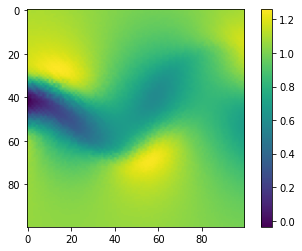

In [ ]:
upl=np.reshape(u_star,(100,100))
plt.imshow(upl)
plt.colorbar()